In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import cv2

from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
torch.manual_seed(42)

(300, 300, 3)


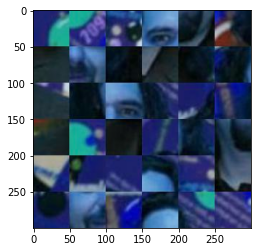

In [2]:
img = cv2.imread("mlware23/dataset/train/faces/024XOWrOBS.jpg")
print(img.shape)
plt.imshow(img)
plt.show()

In [3]:
import pandas as pd
dt = {}
for i in range(6):
    for j in range(6):
        dt[str(i)+str(j)] = str

df = pd.read_csv("mlware23/dataset/train/train_landmarks.csv", dtype=dt)
clss = list(df)
clss = clss[1:]
clss

['00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55']

In [4]:
df.head()

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,AAHRMrGn0B.jpg,00,35,30,52,15,45,04,05,14,...,55,03,33,43,41,50,31,34,21,11
1,jpEcMy3zDs.jpg,42,34,51,32,13,33,04,10,12,...,40,22,05,43,23,14,41,21,52,35
2,uyDprath60.jpg,50,15,14,13,24,12,53,52,23,...,00,02,55,30,22,05,41,20,43,45
3,k4WEXM5f7C.jpg,21,45,53,20,34,52,15,11,54,...,50,02,42,41,14,43,40,32,25,44
4,lG9bsx1nKj.jpg,12,51,01,13,33,15,20,10,22,...,24,34,25,14,55,44,30,23,35,52


In [5]:
df.shape

(3000, 37)

In [6]:
def get_ground_truth(idx):
    img_name = df.loc[idx, "image"]
    im = cv2.imread("mlware23/dataset/train/landmarks/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

In [7]:
df.loc[446, "00"][0]

'1'

<Figure size 432x288 with 0 Axes>

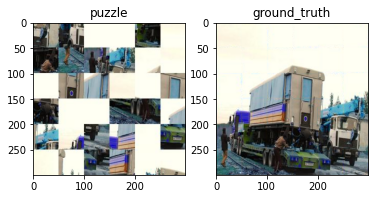

In [8]:
puzzle, solved = get_ground_truth(445)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(solved)
axarr[1].set_title("ground_truth")
plt.show()

In [9]:
crop = 6
size1 = 36*36
imgres = 300
slice1 = 50

In [10]:
# CIFAR images are 300x300
# We consider a simple 6x6 jigsaw puzzle.
# perm_inds = [(0, 0), (50, 0), (50, 50), (0, 50)]
perm_inds = []
for i in range(6):
    for j in range(6):
        perm_inds.append((i*50,j*50))
# Simply maps each pixel to [-1, 1]
img_mean = 0.5
img_std = 0.5
    
def permute6x6(images):
    """
    Splits the images into 6x6 = 36 pieces and randomly permutes the pieces.
    """
    p_images = torch.FloatTensor(images.size())
    perms = torch.LongTensor(images.size()[0], 36)
    for i in range(images.size()[0]):
        p = torch.randperm(36)
        for j in range(6):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[p[j]]
            p_images[i, :, tr:tr+50, tc:tc+50] = images[i, :, sr:sr+50, sc:sc+50]
        perms[i,:] = p
    return(p_images, perms)

def restore6x6(p_images, perms):
    """
    Restores the original image from the pieces and the given permutation.
    """
    images = torch.FloatTensor(p_images.size())
    for i in range(images.size()[0]):
        for j in range(6):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[perms[i, j]]
            images[i, :, sr:sr+slice1, sc:sc+slice1] = p_images[i, :, tr:tr+slice1, tc:tc+slice1]
    return images

def perm2vecmat6x6(perms):
    """
    Converts permutation vectors to vectorized assignment matrices.
    """
    n = perms.size()[0]
    mat = torch.zeros(n, 36, 36)
    # m[i][j] : i is assigned to j
    for i in range(n):
        for k in range(36):
            mat[i, k, perms[i, k]] = 1.
    return mat.view(n, -1)

def vecmat2perm6x6(x):
    """
    Converts vectorized assignment matrices back to permutation vectors.
    Note: this function is compatible with GPU tensors.
    """
    n = x.size()[0]
    x = x.view(n, crop**2, crop**2)
    _, ind = x.max(2)
    return ind
    
def imshow(img, title=None):
    """
    Displays a torch image.
    """
    img = img * img_std + img_mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title != None:
        plt.title(title)

In [11]:
from PIL import Image
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = "mlware23/dataset/train/landmarks/"+self.df["image"].values[idx]
        img = Image.open(file_name)
        if self.transform:
            augmented = self.transform(img)
            img = augmented
        return img

In [12]:
batch_size = 32

transform = transforms.Compose(
    [transforms.Resize(300),
     transforms.ToTensor(),
     transforms.Normalize((img_mean, img_mean, img_mean), (img_std, img_std, img_std))])

In [13]:
train_set = TrainDataset(df,transform)

In [14]:
dataset_dir = "CIFAR10"

In [15]:
# Prepare training, validation, and test samples.
validation_ratio = 0.1
total = len(train_set)
ind = list(range(total))
n_train = int(np.floor((1. - validation_ratio) * total))
train_ind, validation_ind = ind[:n_train], ind[n_train:]
train_subsampler = torch.utils.data.sampler.SubsetRandomSampler(train_ind)
validation_subsampler = torch.utils.data.sampler.SubsetRandomSampler(validation_ind)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_subsampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                sampler=validation_subsampler, num_workers=0)

print('Number of training batches: {}'.format(len(train_loader)))
print('Number of validation batches: {}'.format(len(validation_loader)))

test_set = torchvision.datasets.CIFAR100(root=dataset_dir, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

Number of training batches: 85
Number of validation batches: 10
Files already downloaded and verified


In [16]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def sinkhorn(A, n_iter=4):
    """
    Sinkhorn iterations.
    """
    for i in range(n_iter):
        A /= A.sum(dim=1, keepdim=True)
        A /= A.sum(dim=2, keepdim=True)
    return A

class SimpleConvNet(nn.Module):
    """
    A simple convolutional neural network shared among all pieces.
    """
    def __init__(self):
        super().__init__()
        # 3 x 50 x 50 input
        self.conv1 = nn.Conv2d(3, 8, 5)
        # 8 x 46 x 46
        self.conv2 = nn.Conv2d(8, 8, 5)
        self.conv2_bn = nn.BatchNorm2d(8)
        # 8 x 42 x 42
        self.pool1 = nn.MaxPool2d(2, 2)
        # 8 x 21 x 21
        self.conv3 = nn.Conv2d(8, 16, 5)
        self.conv3_bn = nn.BatchNorm2d(16)
        # 16 x 17 x 17
        self.conv4 = nn.Conv2d(16, 16, 5,stride=2)
        self.conv4_bn = nn.BatchNorm2d(16)
        # 16 x 7 x 7
        self.fc1 = nn.Linear(16 * 7 * 7, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        # 256-d features
        self.fc2 = nn.Linear(256, 256)
        self.fc2_bn = nn.BatchNorm1d(256)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        return x

class JigsawNet(nn.Module):
    """
    A neural network that solves 6x6 jigsaw puzzles.
    """
    def __init__(self, sinkhorn_iter=0):
        super().__init__()
        self.conv_net = SimpleConvNet()
        self.fc1 = nn.Linear(256 * 36, 512)
        self.fc1_bn = nn.BatchNorm1d(512)
        # 6 x 6 assigment matrix
        self.fc2 = nn.Linear(256, 36*36)
        self.sinkhorn_iter = sinkhorn_iter
    
    def forward(self, x):
        # Split the input into four pieces and pass them into the
        # same convolutional neural network.
        x_list = []
        for i in range(6):
            for j in range(6):
                temp = self.conv_net(x[:, :, j*slice1:(j+1)*slice1, i*slice1:(i+1)*slice1])
                x_list.append(temp)
        # x0 = self.conv_net(x[:, :, 0:16, 0:16])
        # x1 = self.conv_net(x[:, :, 16:32, 0:16])
        # x2 = self.conv_net(x[:, :, 16:32, 16:32])
        # x3 = self.conv_net(x[:, :, 0:16, 16:32])
        # Cat
        x = torch.cat(x_list, dim=1)
        # Dense layer
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.sigmoid(self.fc2(x))
        if self.sinkhorn_iter > 0:
            x = x.view(-1, 36)
            x = sinkhorn(x, self.sinkhorn_iter)
            x = x.view(-1, 36*36)
        return x

In [17]:
# Test helper
def compute_acc(p_pred, p_true, average=True):
    """
    We require that the location of all six pieces are correctly predicted.
    Note: this function is compatible with GPU tensors.
    """
    # Remember to cast to float.
    n = torch.sum((torch.sum(p_pred == p_true, 1) == 6).float())
    if average:
        return n / p_pred.size()[0]
    else:
        return n

# Training process
def train_model(model, criterion, optimizer, train_loader, validation_loader,
                n_epochs=40, save_file_name=None):
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []
    for epoch in range(n_epochs):
        with tqdm_notebook(total=len(train_loader), desc="Epoch {}".format(epoch + 1), unit='b', leave=False) as pbar:
            # Training phase
            model.train()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(train_loader):
                inputs = data
                x_in, perms = permute6x6(inputs)
                y_in = perm2vecmat6x6(perms)
                n_samples += inputs.size()[0]
                if torch.cuda.is_available():
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                optimizer.zero_grad()
                outputs = model(x_in)
                n_correct_pred += compute_acc(vecmat2perm6x6(outputs), perms, False).data[0]
                loss = criterion(outputs, y_in)
                loss.backward()
                optimizer.step()
                running_loss += loss.data[0] * x_in.size()[0]
                pbar.update(1)
            loss_history.append(running_loss / n_samples)
            acc_history.append(n_correct_pred / n_samples)
            
            # Validation phase
            model.eval()
            running_loss = 0.
            n_correct_pred = 0
            n_samples = 0
            for i, data in enumerate(validation_loader, 0):
                inputs = data
                x_in, perms = permute6x6(inputs)
                y_in = perm2vecmat6x6(perms)
                n_samples += inputs.size()[0]
                if torch.cuda.is_available():
                    x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
                    perms = Variable(perms.cuda())
                else:
                    x_in, y_in = Variable(x_in), Variable(y_in)
                    perms = Variable(perms)
                outputs = model(x_in)
                n_correct_pred += compute_acc(vecmat2perm6x6(outputs), perms, False).data[0]
                loss = criterion(outputs, y_in)
                running_loss += loss.data[0] * x_in.size()[0]
            val_loss_history.append(running_loss / n_samples)
            val_acc_history.append(n_correct_pred / n_samples)
            
            # Update the progress bar.
            print("Epoch {0:03d}: loss={1:.4f}, val_loss={2:.4f}, acc={3:.2%}, val_acc={4:.2%}".format(
                epoch + 1, loss_history[-1], val_loss_history[-1], acc_history[-1], val_acc_history[-1]))
    print('Training completed')
    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
        'acc': acc_history,
        'val_acc': val_acc_history
    }
    # Save the model when requested.
    if save_file_name is not None:
        torch.save({
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, save_file_name)
    return history

# Test process
# Compute the accuracy
def test_model(model, test_loader):
    running_acc = 0.
    n = 0
    model.eval()
    for i, data in enumerate(test_loader, 0):
        inputs = data
        x_in, perms = permute6x6(inputs)
        y_in = perm2vecmat6x6(perms)
        if torch.is_cuda_available():
            x_in, y_in = Variable(x_in.cuda()), Variable(y_in.cuda())
        else:
            x_in, y_in = Variable(x_in), Variable(y_in)
        pred = model(x_in)
        perms_pred = vecmat2perm6x6(pred.cpu().data)
        running_acc += compute_acc(perms_pred, perms, False)
        n += x_in.size()[0]
    acc = running_acc / n
    return acc

In [18]:
n_epochs = 100
sinkhorn_iter = 5

# Create the neural network.
model = JigsawNet(sinkhorn_iter=sinkhorn_iter)
is_cuda_available = torch.cuda.is_available()
if is_cuda_available:
    model.cuda()

n_params = 0
for p in model.parameters():
    n_params += np.prod(p.size())
print('# of parameters: {}'.format(n_params))

# We use binary cross-entropy loss here.
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train
save_file_name = 'jigsaw_cifar100_e{}_s{}.pk'.format(n_epochs, sinkhorn_iter)
history = train_model(model, criterion, optimizer, train_loader, validation_loader,
                      n_epochs=n_epochs, save_file_name=save_file_name)

# of parameters: 5332904


C:\Users\shres\AppData\Local\Temp/ipykernel_12888/3417860783.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(train_loader), desc="Epoch {}".format(epoch + 1), unit='b', leave=False) as pbar:


Epoch 1:   0%|          | 0/85 [00:00<?, ?b/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x512 and 256x1296)

In [ ]:
torch.cuda.is_available()

In [ ]:
plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()
plt.figure()
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
#Calculate accuracy
print('Training accuracy: {}'.format(test_model(model, train_loader)))
print('Validation accuracy: {}'.format(test_model(model, validation_loader)))
print('Test accuracy: {}'.format(test_model(model, test_loader)))
# Here training accuracy will be higher because dropout is disabled

In [ ]:
# Let us try some test images.
test_data_iter = iter(test_loader)
test_images, _ = test_data_iter.next()
p_images, perms = permute6x6(test_images)

# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
plt.title('Inputs')
plt.show()

model.eval()
if is_cuda_available:
    pred = model(Variable(p_images.cuda()))
else:
    pred = model(Variable(p_images))
perms_pred = vecmat2perm6x6(pred.cpu().data)

# Show restored images.
plt.figure()
imshow(torchvision.utils.make_grid(restore6x6(p_images, perms_pred)))
plt.title('Restored')
plt.show()